# notMNIST
- You can find my repository on notMNIST <a href="https://github.com/AmmarRashed/notMNIST">here</a>

In [1]:
from __future__ import print_function, division, absolute_import
from six.moves import cPickle as pickle

In [2]:
import os, time

import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

### Loading data

In [4]:
image_size = 28
pixel_depth = 255
data_root = 'data'

In [5]:
pickle_file  = os.path.join(data_root, 'notMNIST.pickle')
keys = ["{0}_{1}".format(t,x) for t in ["train","test"] for x in "Xy"]+["labels_dict"]
with open(pickle_file, 'rb') as f:
    pi = pickle.load(f)
    for k in keys:
        globals()[k] = pi[k]
_, valid_X, __, valid_y = train_test_split(train_X, train_y, test_size=0.05)
del _, __

tensorify = lambda mat: mat.reshape(-1, image_size, image_size)
train_X, valid_X, test_X = (tensorify(i) for i in [train_X, valid_X, test_X])

print(train_X.shape, valid_X.shape, test_X.shape)

(529114, 28, 28) (26456, 28, 28) (18724, 28, 28)


In [6]:
nclasses = len(labels_dict)
labels_dict

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9}

In [7]:
def generate_batch(X, y, batch_size=10):
    global labels_dict
    j = 0
    while 1:
        i = j
        if i+batch_size < len(X):
            j = i + batch_size
            raw_labels = train_y[i:i+batch_size]
            yield X[i:i+batch_size], raw_labels.flatten()
        else:
            j = 0
            raw_labels = np.concatenate((y[i:], y[0:batch_size-(len(y)-i)]))
            yield np.concatenate((X[i:], X[0:batch_size-(len(X)-i)])),\
                    raw_labels.flatten()
        

In [8]:
learning_rate = 0.001
batch_size = 1000
h_size = 128

In [9]:
graph = tf.Graph()
with graph.as_default():
    with tf.name_scope("inputs"):
        x = tf.placeholder(tf.float32, shape=[None, image_size, image_size])
        y = tf.placeholder(tf.int32, shape=[None])
        keep_prob = tf.placeholder_with_default(0.5, None, name='keep_prob')
        rnn_cell = tf.contrib.rnn.BasicRNNCell(h_size)
        
        rnn_cell = tf.contrib.rnn.DropoutWrapper(rnn_cell, input_keep_prob=keep_prob)
            
        outputs, states = tf.nn.dynamic_rnn(rnn_cell, x, dtype=tf.float32)
    
        logits = tf.layers.dense(states, nclasses)
        
    with tf.name_scope("Loss"):
        cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=y))

    with tf.name_scope("Optimizer"):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
        
    with tf.name_scope("Accuracy"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [10]:
def run_session(graph, epochs, learning_rate, batch_size, p_every=25):
    start = time.time()
    test_accuracies = dict()
    valid_accuracies = dict()
    losses = dict()
    batches = generate_batch(train_X, train_y, batch_size=batch_size)

    with tf.device("/gpu"), tf.Session(graph=graph) as sess:
        init.run()
        print("Variables initialized")
        average_loss = 0
        for e in range(epochs+1):
            batch_X, batch_y = batches.__next__()
            feed_dict = {x:batch_X, y:batch_y, keep_prob:0.5}
            _, loss = sess.run([optimizer, cross_entropy], feed_dict=feed_dict)
            average_loss += np.mean(loss)
            if e%p_every == 0:
                print("Epoch {0}\nCross-entropy loss: {1}".format(e,average_loss/p_every if e>0 else average_loss))
                losses[e] = average_loss
                average_loss = 0
                valid_accuracy = np.mean(sess.run([accuracy], feed_dict={x:valid_X, y:valid_y, keep_prob:1.0}))
                test_accuracy = np.mean(sess.run([accuracy], feed_dict={x:test_X, y:test_y, keep_prob:1.0}))
                test_accuracies[e] = test_accuracy
                valid_accuracies[e] = valid_accuracy
                print("Validation Accuracy:{0}".format(valid_accuracy))
                print("Test Accuracy:{0}".format(test_accuracy))
                print("~"*40)
    print("Took: {}".format(time.time()-start))

    fig, ax1 = plt.subplots(figsize=(12,7))
    xticks = sorted(losses.keys())
    data1_valid = [valid_accuracies[i] for i in xticks]
    data1_test = [test_accuracies[i] for i in xticks]
    data2 = [losses[i] for i in xticks]

    color = 'tab:blue'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy', color=color)
    ax1.plot(xticks, data1_valid, color=color)
    ax1.plot(xticks, data1_test, color='tab:green')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Cross-entropy loss', color=color)
    ax2.plot(xticks, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    ax1.legend(['Valid. accuracy', 'test. accuracy'], loc='upper center')
    ax2.legend(['Test Cross-entropy loss'])
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

Variables initialized
Epoch 0
Cross-entropy loss: 2.4698288440704346
Validation Accuracy:0.1463940143585205
Test Accuracy:0.14863276481628418
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 25
Cross-entropy loss: 1.735975170135498
Validation Accuracy:0.5881463289260864
Test Accuracy:0.6599551439285278
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 50
Cross-entropy loss: 1.2399467754364013
Validation Accuracy:0.6959102153778076
Test Accuracy:0.7667165398597717
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 75
Cross-entropy loss: 1.0787364745140076
Validation Accuracy:0.7343891859054565
Test Accuracy:0.8084810972213745
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 100
Cross-entropy loss: 0.9986264276504516
Validation Accuracy:0.7537798881530762
Test Accuracy:0.830057680606842
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 125
Cross-entropy loss: 0.9250686287879943
Validation Accuracy:0.7653462290763855
Test Accuracy:0.8398312330245972
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 150
Cr

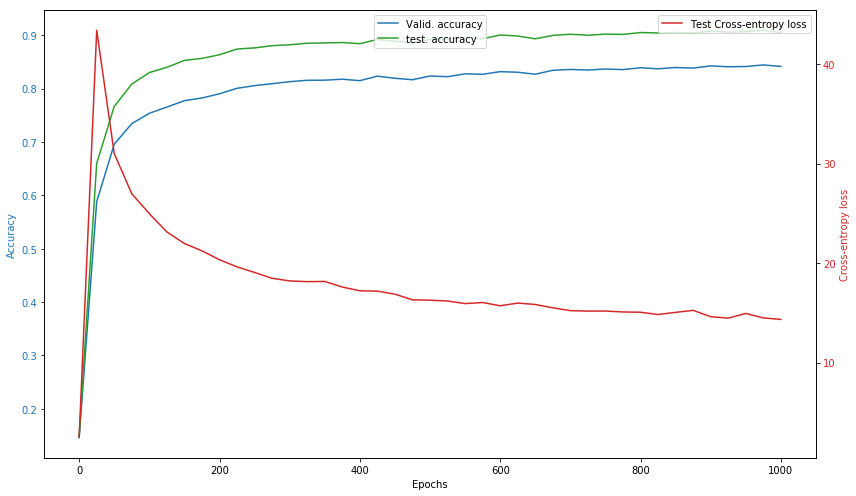

In [11]:
epochs = 1000
run_session(graph, epochs, learning_rate, batch_size)

### Using `LSTMCell`
<img src="https://github.com/AmmarRashed/notMNIST/blob/master/misc/lstm_diagram.png?raw=true">

In [12]:
graph_lstm = tf.Graph()
with graph_lstm.as_default():
    with tf.name_scope("inputs"):
        x = tf.placeholder(tf.float32, shape=[None, image_size, image_size])
        y = tf.placeholder(tf.int32, shape=[None])
        lstm_cell = tf.contrib.rnn.LSTMCell(h_size)
        keep_prob = tf.placeholder_with_default(0.5, None, name='keep_prob')
    
    with tf.name_scope("lstm"):
        lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, input_keep_prob=keep_prob)
            
        outputs, states = tf.nn.dynamic_rnn(lstm_cell, x, dtype=tf.float32)
    
        top_layer_h_state = states[-1]
        logits = tf.layers.dense(top_layer_h_state, nclasses, name="softmax")
        
#         logits = tf.contrib.layers.fully_connected(states, nclasses, activation_fn=None)
        
    with tf.name_scope("Loss"):
        cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=y))

    with tf.name_scope("Optimizer"):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
        
    with tf.name_scope("Accuracy"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Variables initialized
Epoch 0
Cross-entropy loss: 2.3701000213623047
Validation Accuracy:0.12405503541231155
Test Accuracy:0.1276436597108841
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 25
Cross-entropy loss: 1.6719712591171265
Validation Accuracy:0.6794300079345703
Test Accuracy:0.7473830580711365
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 50
Cross-entropy loss: 0.943428122997284
Validation Accuracy:0.780427873134613
Test Accuracy:0.8518478870391846
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 75
Cross-entropy loss: 0.7343191504478455
Validation Accuracy:0.8104400038719177
Test Accuracy:0.8782845735549927
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 100
Cross-entropy loss: 0.6627474093437195
Validation Accuracy:0.8288478851318359
Test Accuracy:0.8933454155921936
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 125
Cross-entropy loss: 0.6125157713890076
Validation Accuracy:0.8354626297950745
Test Accuracy:0.9005020260810852
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 150
Cr

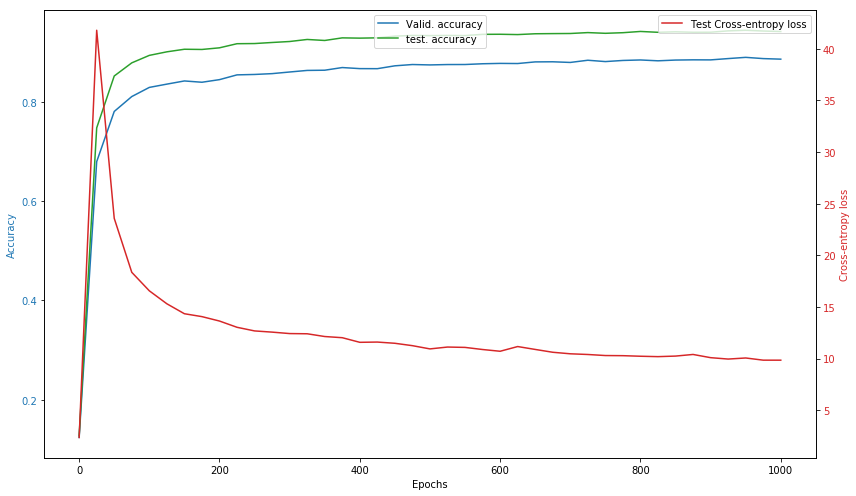

In [13]:
run_session(graph_lstm, epochs, learning_rate, batch_size)

### Using multiple `GRUCell`s

In [16]:
graph_gru = tf.Graph()
n_layers = 3

with graph_gru.as_default():
    with tf.name_scope("inputs"):
        x = tf.placeholder(tf.float32, shape=[None, image_size, image_size])
        y = tf.placeholder(tf.int32, shape=[None])
        gru_cells = [tf.contrib.rnn.LSTMCell(h_size) for i in range(n_layers)]
        keep_prob = tf.placeholder_with_default(0.5, None, name='keep_prob')
        
    with tf.name_scope("gru"):
        gru_cells = [tf.contrib.rnn.DropoutWrapper(gru_cell, input_keep_prob=keep_prob) for gru_cell in gru_cells]
        
        deep_gru = tf.contrib.rnn.MultiRNNCell(gru_cells)
        
        outputs, states = tf.nn.dynamic_rnn(deep_gru, x, dtype=tf.float32)
    
        top_layer_h_state = states[-1][-1]
        logits = tf.layers.dense(top_layer_h_state, nclasses, name="softmax")
        
#         logits = tf.contrib.layers.fully_connected(states, nclasses, activation_fn=None)
        
    with tf.name_scope("Loss"):
        cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=y))

    with tf.name_scope("Optimizer"):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
        
    with tf.name_scope("Accuracy"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Variables initialized
Epoch 0
Cross-entropy loss: 2.3016345500946045
Validation Accuracy:0.299062579870224
Test Accuracy:0.32679983973503113
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 25
Cross-entropy loss: 1.5297716712951661
Validation Accuracy:0.6832098364830017
Test Accuracy:0.7440717816352844
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 50
Cross-entropy loss: 0.8819349837303162
Validation Accuracy:0.7959631085395813
Test Accuracy:0.8662145137786865
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 75
Cross-entropy loss: 0.7046147060394287
Validation Accuracy:0.8209857940673828
Test Accuracy:0.8900876045227051
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 100
Cross-entropy loss: 0.6408850765228271
Validation Accuracy:0.8316828012466431
Test Accuracy:0.8982055187225342
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 125
Cross-entropy loss: 0.599220540523529
Validation Accuracy:0.8347823023796082
Test Accuracy:0.8995407223701477
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 150
Cr

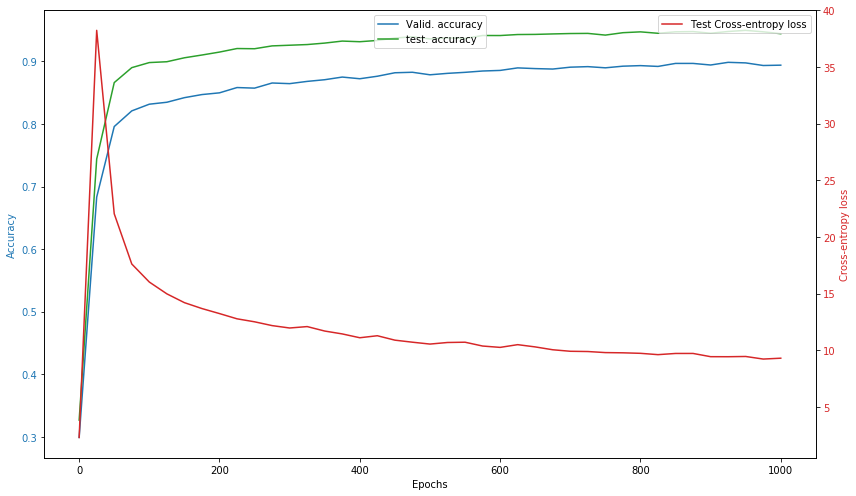

In [17]:
run_session(graph_gru, epochs, learning_rate, batch_size)